Creates different kinds of plots for a single transmon with two qubits.

In [1]:
from typing import Tuple
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt

import four_level_transmons.plotting as plotting
import four_level_transmons.utilities as utilities
from c3.model import Model
from c3.utils import qt_utils
from c3.utils import tf_utils

np.set_printoptions(linewidth=300)

2022-10-27 12:45:27.086492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 12:45:27.086518: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Helper functions and preparation

In [2]:
# Helper functions
def getModel() -> Model:
    qubit_levels = [5]
    qubit_frequencies = [5e9]
    anharmonicities = [-300e6]
    t1s = [25e-6]
    t2stars = [35e-6]
    qubit_temps = 50e-3
    couplingStrength = 20e6
    qubits = utilities.createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s, t2stars, qubit_temps)
    coupling = utilities.createChainCouplings([couplingStrength], qubits)
    model = Model(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)
    return model


def getHamiltonian():
    return getModel().get_Hamiltonian()


def cutSpectrum(frequencies: np.array, amplitudes: np.array, limits: Tuple[float, float]) -> Tuple[np.array, np.array]:
    """
    Cuts the two lists of frequencies and corresponding amplitudes at a lower and upper frequency cutoff. Returns both lists after cutting.
    """
    leftCut = np.argwhere(frequencies > limits[0]).flatten()
    leftIdx = leftCut[0] if len(leftCut) > 0 else 0
    rightCut = np.argwhere(frequencies < limits[1]).flatten()
    rightIdx = rightCut[-1] if len(rightCut) > 0 else -1
    return frequencies[leftIdx:rightIdx], amplitudes[leftIdx:rightIdx]

In [3]:
# Create the energy level labels
level_labels_transmon_bra = ["\\langle 0,0|", "\\langle 0,1|", "\\langle 1,0|", "\\langle 1,1|", "leakage"]
level_labels_transmon_ket = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle", "leakage"]
level_labels_transmon_ket = [(f"${x}$" if x.startswith('|') else x) for x in level_labels_transmon_ket]
level_labels_transmon_bra = [(f"${x}$" if x.endswith('|') else x) for x in level_labels_transmon_bra]
level_labels_short = [f"{x}" for x in range(5)]

# Calculate all energy eigenstates
stateEnergies = []
H = getHamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)

# Combine all energies with labels
indices = [np.argmax(np.round(evecs[i], 2)) for i in range(len(evals))]
for i, x in enumerate(level_labels_short):
    if level_labels_short[i] is not None:
        energy = evals[indices[i]]
        stateEnergies.append((energy, x))

# Calculate all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

2022-10-27 12:45:29.270539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 12:45:29.270600: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 12:45:29.270654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-10-27 12:45:29.271845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Reads a propagator from a file and plots it

Infidelity:  [0.00561175]


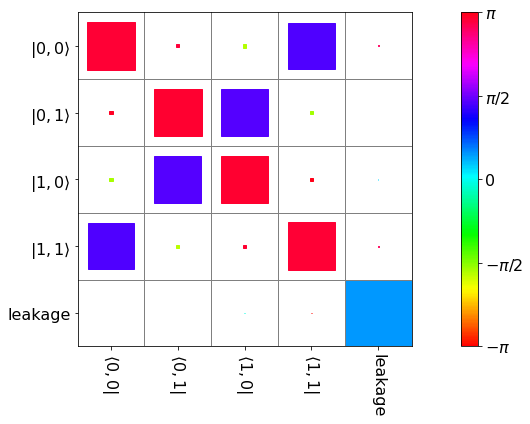

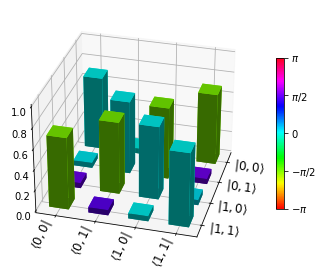

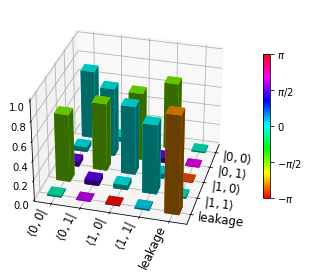

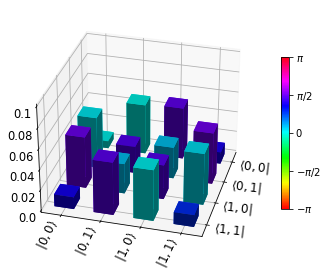

In [10]:
# Load and project the propagator
propagator = np.load('/home/user/Schreibtisch/results/4-level qubit/2 LOs/1 transmon/double iSWAP 40ns/propagator_after.npy')
propagatorProjected = tf_utils.tf_project_to_comp(
    propagator, dims=[5], index=[0, 1], outdims=[4]
)

# Define an ideal gate and compute the fidelity
name = 'universal_entangler'
#ideal = qt_utils.np_kron_n([constants.GATES["rz90p"], constants.Id])
#ideal = custom_gates.GATE_CZ_t1q2_t2q2
#ideal = np.eye(16) + 0.0j * np.eye(16)
ideal = np.array([[1,0,0,-1j], [0,1,-1j,0], [0,-1j,1,0], [-1j,0,0,1]]) / np.sqrt(2.0)
idealPadded = qt_utils.pad_matrix(ideal, propagator.shape[0] - ideal.shape[0], 'fulluni')
print("Infidelity: ", 1.0 - tf_utils.tf_unitary_overlap(propagatorProjected, ideal).numpy())

# Correct the global phase in the propagator, which might be different from the ideal gate
phase = np.angle(ideal[0,0]) - np.angle(propagator[0,0])
propagatorCorrected = propagator * np.exp(1.0j * phase)
propagatorCorrectedProjected = tf_utils.tf_project_to_comp(
    propagatorCorrected, dims=[5], index=[0, 1], outdims=[4]
)

# Create the plots
baseDir = "/home/user"
plotting.plotComplexMatrixHinton(propagator, maxAbsolute=1, xlabels=level_labels_transmon_bra,
                                 ylabels=level_labels_transmon_ket, gridColour="gray",
                                 filename=f'{baseDir}/{name}_propagator.pdf', colourMap='hsv', tickLabelSize=16,
                                 #comparisonMatrix=ideal
                                 )
plotting.plotComplexMatrix(propagatorCorrectedProjected, colourMap='hsv', xlabels=level_labels_transmon_bra[:4],
                           ylabels=level_labels_transmon_ket[:4], filename=f'{baseDir}/rx90p_q2_propagator_3d.svg')
plotting.plotComplexMatrix(propagatorCorrected, colourMap='hsv', xlabels=level_labels_transmon_bra,
                           ylabels=level_labels_transmon_ket, filename=f'{baseDir}/rx90p_q2_propagator_3d.svg')
plotting.plotComplexMatrix(propagatorCorrectedProjected - ideal, xlabels=level_labels_transmon_ket[:4],
                           ylabels=level_labels_transmon_bra[:4], filename=f'{baseDir}/{name}_propagator_diff.pdf',
                           colourMap='hsv', zlimits=(0.0, 0.1), zticks=np.round(np.arange(0.0, 0.11, 0.02), 2))

### Reads a time dependent signal and plots it

In [ ]:
time, signal = np.load('/home/user/Schreibtisch/results/4-level qubit/Fourier basis 5 levels, 1000ns/17 freqs/unity/signal_t1_after.npy')

fig, ax = plt.subplots(1,1)
ax.plot(time * 1e9, signal / 1e6)
ax.set_xlabel("Time [ns]", fontsize=14)
ax.set_ylabel("Amplitude [MHz]", fontsize=14)
plt.tight_layout()
plt.savefig('/home/user/rz90p_q2_signal.pdf', bbox_inches="tight", dpi=100)
plt.show()

### Plots the frequency spectrum of the above signal

/home/user/c3/venv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_14519/273407859.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_gdpPercapinches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('/home/user/rx90p_q2_spectrum.pdf', bbox_gdpPercapinches="tight", dpi=100)


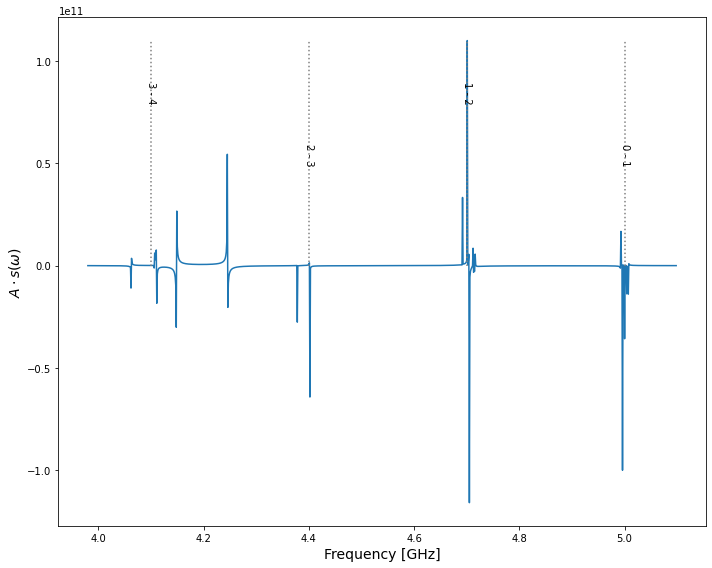

In [29]:
frequencyRange = (3.98e9, 5.1e9)

# Calculate the spectrum
freq_signal = np.fft.rfft(signal)
freq = np.fft.rfftfreq(len(time), time[-1] / len(time))
freq, freq_signal = cutSpectrum(freq, freq_signal, frequencyRange)
#freq_signal /= np.max(np.abs(freq_signal))

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.subplots(1, 1)
plt.plot(freq / 1e9, freq_signal)
plt.xlabel("Frequency [GHz]", fontsize=14)
plt.ylabel("$A\cdot s(\omega)$", fontsize=14)

# Add labels for the model's resonances
if True:
    states = transitions
    # only transitions within a range
    inRange = [s for s in states if frequencyRange[0] < s[0] < frequencyRange[1]]
    energies = np.array([s[0] for s in inRange])
    labels = np.array([s[1] for s in inRange])
    sortedIndices = np.argsort(energies)

    # a tick for each transition energy
    for i,idx in enumerate(sortedIndices):
        ax.vlines(energies[idx] / 1e9, 0.0e11, 1.1e11, colors=["grey"], linestyles=":")
        y = 0.8e11 if i%2==0 else 0.5e11
        ax.annotate(
            text=labels[idx],
            #xy=((mean - frequencyRange[0]) / (frequencyRange[1] - frequencyRange[0]), 0.68),
            xy=(energies[idx] / 1e9, y),
            #xycoords="axes fraction",
            #xycoords="data",
            #verticalalignment="bottom",
            horizontalalignment="center",
            rotation=270,
        )

# Add binned labels for the model's resonances
if False:
    # binned transitions within the range
    bins = np.linspace(frequencyRange[0], frequencyRange[1], 20)
    digitised = np.digitize(energies, bins)
    binnedEnergies = [energies[digitised == i] for i in range(1, len(bins))]
    binnedLabels = [labels[digitised == i] for i in range(1, len(bins))]

    filtered = list(filter(lambda x: len(x[0]) > 0, zip(binnedLabels, binnedEnergies)))
    letters = iter(list(string.ascii_uppercase))
    for i in range(len(filtered)):
        #label = " / ".join(list(filtered[i][0]))
        label = filtered[i][0][0]
        mean = filtered[i][1][0] #np.array(filtered[i][1]).mean()
        # plot rotated transition labels above each tick
        ax.annotate(
            text=label,
            #xy=((mean - frequencyRange[0]) / (frequencyRange[1] - frequencyRange[0]), 0.68),
            xy=(mean/1e9, 0.75e11),
            #xycoords="axes fraction",
            #xycoords="data",
            #verticalalignment="bottom",
            horizontalalignment="center",
            rotation=270,
        )
        # plot transition labels below the plot with a letter at each tick
        '''
        letter = next(letters)
        ax.annotate(
            text=letter,
            xy=((mean - frequencyRange[0]) / (frequencyRange[1] - frequencyRange[0]), 1.01),
            xycoords="axes fraction",
            verticalalignment="bottom",
            horizontalalignment="center"
        )
        ax.annotate(f"{letter}: {label}", (0, 0), (0, -40 - i * 10), xycoords='axes fraction',
                      textcoords='offset points', va='top')
        '''

plt.tight_layout()
plt.savefig('/home/user/rx90p_q2_spectrum.pdf', bbox_gdpPercapinches="tight", dpi=100)
plt.show()